# Merge two traces from Track Mate

In [1]:

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./_modules")
import TrackMerger as tm

import numpy as np
import math

import TrackTiffDataExtractor as tiffExtractor


############
#parameters
############

trackListFileA = "/Volumes/SCIENCE/science/mary_atg/3_atg1_atg13/0426 MG134/134_M1_GFPstack_Tracks.xml"
trackListFileB = "/Volumes/SCIENCE/science/mary_atg/3_atg1_atg13/0426 MG134/134_M1_RFPstack_Tracks.xml"

fpA = r'/Volumes/SCIENCE/science/mary_atg/3_atg1_atg13/0426 MG134/m2_w1L-SP_GFPex_t_all.tif'
fpB = r'/Volumes/SCIENCE/science/mary_atg/3_atg1_atg13/0426 MG134/m2_w2L-SP_RFPex_t_all.tif'

outputFolder = "/Volumes/SCIENCE/science/mary_atg/3_atg1_atg13/0426 MG134/m1_output/"

#distance in pixels below which two tracks are regarded as potential matches
matchDistanceTreshold = 10;

# number of time points collected in every stack
maxNTimePoints=49

./_modules/tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"


In [2]:
# this method tests multiple distance tresholds for track matching. 
# The distance treshold should be chosen such that the searchradius does not become too large
# to include fals positive matches (10px is a good choice)

# this has only to be done once
#tm.determineDistanceTresholdForMatching(trackListFileA,trackListFileB,matchDistanceTreshold)

In [2]:
uniqueTracksA,uniqueTracksB,mergedTracksAB = tm.matchTracks(trackListFileA,trackListFileB,matchDistanceTreshold,maxNTimePoints,verbose=False)

tm.plotTrackLengthHistogram(tm.parseTraceListFromFile(trackListFileA),'green')
tm.plotTrackLengthHistogram(tm.parseTraceListFromFile(trackListFileB),'red')
tm.plotTrackLengthHistogram(mergedTracksAB,'blue')

mergedTracksAB_readyForTiffExtraction = tm.preprocessTracksForTiffExtraction(mergedTracksAB,maxNTimePoints)

IOError: [Errno 2] No such file or directory: '/Volumes/SCIENCE/science/mary_atg/3_atg1_atg13/0426 MG134/134_M1_GFPstack_Tracks.xml'

# Get the data from the TIFF files

In [5]:


# I had to comment out the tif.close() in order to avoid a UnboundLocalError exception.


stackA = tiffExtractor.readStack(fpA)
stackB = tiffExtractor.readStack(fpB)


# Investigate One particular Track

In [6]:
#TrackIdWeAreInterestedIn = 13
#
#trackAvgPosition = tm.getAveragePositionForTrack(mergedTracksAB[TrackIdWeAreInterestedIn])
#tiffExtractor.plotTrackCoordinatesInBothStackFrames(stackA,stackB,5,(trackAvgPosition[0],trackAvgPosition[1]))



In [7]:
#trackToPlotCoordinates = mergedTracksAB_readyForTiffExtraction[TrackIdWeAreInterestedIn]
#imageSize = 100
#trackFocusImages_stackA = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackA,imageSize/2)
#trackFocusImages_stackB = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackB,imageSize/2)
#
#tiffExtractor.showTwoListsOfImagesOneBelowTheOtherInSubplotGrid_colorbar(trackFocusImages_stackA,trackFocusImages_stackB,nColumns=7)

# Fit Gaussian

In [8]:
def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [9]:
import pandas
import scipy.optimize as opt
def fitGaussian(particleImage):
    x = range(0,len(particleImage))
    y = range(0,len(particleImage[0]))
    (x, y) = np.meshgrid(x, y)
    # (amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
    initial_guess = (30000.,len(particleImage)/2.,len(particleImage)/2.,5.,5.,1.,1.)
    try:
        popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), particleImage.reshape(len(particleImage)*len(particleImage[0])), p0=initial_guess)
        debug = False
        if(debug):
            paramLabels = ["amplitude", "xo", "yo", "sigma_x", "sigma_y", "theta", "offset"]
            asdf=pandas.DataFrame(zip( initial_guess, popt,initial_guess-popt),paramLabels,["initParam","popt","diff"])
            print(asdf)
    except RuntimeError:
        return([0,0,0,0,0,0,0])
#    return([popt[0]-popt[6], # (amplitude-offset
#            (popt[3]+popt[4])/2., # mean(sigmas)
#            popt[0], #amplitude
#            popt[3],#sigmaX
#            popt[4], #sigmaY
#            popt[6]])#offset
    return popt
 

In [10]:
def plotGaussianFit(particleImage,popt,option="gauss"):
    x = range(0,len(particleImage))
    y = range(0,len(particleImage[0]))
    (x, y) = np.meshgrid(x, y)
    
    if(popt[0]==None):
        plt.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower'
        plt.show()
        return(None)
    
    data_fitted = twoD_Gaussian((x, y), *popt)

    if(option=="all"):
        fig, axs = plt.subplots(1, 3)
        ax = axs[0]
        ax.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower')
        
        ax = axs[1]
        ax.imshow(data_fitted.reshape(len(particleImage), len(particleImage)))#,origin='lower')
        
        ax = axs[2]
        ax.hold(True)
        ax.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower')
        ax.contour(x, y, data_fitted.reshape(len(particleImage), len(particleImage)), 8, colors='w')
        fig.show()
    if(option=="gauss"):
        plt.imshow(data_fitted.reshape(len(particleImage), len(particleImage)))#,origin='lower')
        plt.show()
    if(option=="overlay"):
        plt.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower')
        plt.contour(x, y, data_fitted.reshape(len(particleImage), len(particleImage)), 8, colors='w')
        plt.show()
    return(data_fitted.reshape(len(particleImage), len(particleImage)))


In [11]:
### Plotting function for the Track focus images in two conditions, have a colorbar as well

# the clipping treshold is an normalized intensity value above which pixel intensities are treated as puncta
# and below which it is regarded as other intensity sources (noise, cell fluorescence)
# it prooved well to use the brightest 10% of the pixels to determine the puncta, i.e. the value is 0.9
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
def doGaussianFitAndPlotResults(imageListA,imageListB,nColumns,clippingThreshold=0.9,outputFilename="output.png"):
    setBlinewidth = 2.5
    stack = imageListA
    # the min and max values of the color map
    vMax = np.max((np.max((imageListA[0])),np.max((imageListB[0]))))
    vMin = np.min((np.min((imageListA[0])),np.min((imageListB[0]))))
    xRange = len(imageListA[0])
    yRange = len(imageListA[0][0])
    
    
    
    #n columns for display
    nRows = int(math.ceil(len(stack)/nColumns))
    rowCounter = 0
    colCounter = 0
    frameSubtractor=0
    
    plt.close('all')
    fig, axs = plt.subplots(nrows=2*nRows, ncols=nColumns, sharex=True, sharey=True)    
    gaussianFitResults_A = []
    gaussianFitResults_B = []
    
    for counter in range(0,2*len(stack)):
        frameId = counter-frameSubtractor
        
        ax = axs[rowCounter][colCounter]
        
        #---- 
        # determine which image is plotted, from set A or B
        if(rowCounter%2==0):    
            particleImage = imageListA[frameId]
            ax.set_title("A frame "+str(frameId), fontsize=8, fontweight='bold')
            #make small horizontal bars
            ax.axvspan(0-0.04*xRange, xRange*0.2, 1.05, 1.1, clip_on=False,color='grey')
            ax.axvspan(xRange*0.8, xRange*1.04, 1.05, 1.1, clip_on=False,color='grey')
            
        else:        
            particleImage = imageListB[frameId]
            ax.set_title("B frame "+str(frameId), fontsize=8, fontweight='bold')
            # better distinguish the other condition:
            #ax.spines['top'].set_visible(False)
            ax.spines['top'].set_linewidth(setBlinewidth)
            ax.spines['right'].set_linewidth(setBlinewidth)
            ax.spines['bottom'].set_linewidth(setBlinewidth)
            ax.spines['left'].set_linewidth(setBlinewidth) 
    
        
        #---- 
        # perform the gaussian fit
        
        # where the magic happens
        clipingIndex = int( clippingThreshold* len(particleImage.flatten()))
        lowClipping = np.sort(particleImage.flatten())[clipingIndex]
        clippedParticleImage=np.clip(particleImage, lowClipping, np.max(particleImage))

        #determine the best fit
        popt = fitGaussian(clippedParticleImage)
        if(rowCounter%2==0):  
            gaussianFitResults_A.append(np.append(popt,lowClipping))
        else:
            gaussianFitResults_B.append(np.append(popt,lowClipping))
        

        #---- 
        # plot the results of the fit
        x = range(0,len(particleImage))
        y = range(0,len(particleImage[0]))
        (x, y) = np.meshgrid(x, y)
        data_fitted = twoD_Gaussian((x, y), *popt)

        im = ax.imshow(particleImage, cmap=plt.cm.jet,vmin=vMin, vmax=vMax)#,origin='lower')
        #if the fit failed, do not plot a contour
        if(popt[0]!=0):
            try:
#            ax.contour(x, y, data_fitted.reshape(len(particleImage), len(particleImage[0])), 8, colors='w')
                ax.contour(x, y, data_fitted.reshape(len(y), len(x)), 8, colors='w')
            except ValueError:
                print("oops")
                    #oops..
        
        #---- 
        # plot a color bar to the rightmost images

        
        # creates a new axis, cax, located 0.05 inches to the right of ax, whose width is 15% of ax
        # cax is used to plot a colorbar for each subplot
        div = make_axes_locatable(ax)
        cax = div.append_axes("right", size="2%",pad=None)# pad=0.05)
        #ticks=np.arange(0,10,.1),
        if(colCounter==nColumns-1):
            cbar = plt.colorbar(im, cax=cax,  format="%.2g")
            #cbar.set_label('Colorbar {}'.format(i), size=10)
        else:
            #cbar = plt.colorbar(im, cax=cax,  format="%.2g")
            # set the axes invisible if it is not used for a colorbar
            cax.axis('off')
            cax.get_xaxis().set_visible(False)
            cax.axes.get_yaxis().set_visible(False)

            
        #---- 
        # take care of rows and columns in the plot
        colCounter=colCounter+1;        
        if(colCounter>=nColumns):
            rowCounter = rowCounter+1;
            if(rowCounter%1==0):
                frameSubtractor +=nColumns
            if(rowCounter%2==0):
                frameSubtractor -=nColumns
            colCounter = 0
    
    
    fig.set_size_inches(15,30)
    fig.savefig(outputFilename, bbox_inches='tight')
    return [gaussianFitResults_A,gaussianFitResults_B]



In [12]:
#paramLabels = ["amplitude", "xo", "yo", "sigma_x", "sigma_y", "theta", "offset"]
def analyzeGaussFitResults(results,outputFilename):
    resultsA = results[0]
    resultsB = results[1]
    
    observables_A = computeObservables(resultsA)
    observables_B = computeObservables(resultsB)
    
    
    frameIds = range(0,len(resultsA))
    amplitudes_A = np.array(resultsA)[:,1]
    amplitudes_B = np.array(resultsB)[:,1]
    
    
    fig, axs = plt.subplots(3, 2,sharex=True)
    
    #offset = (np.array(gaussianFitResults[0:30]))[:,2]
    #x = [row[0] for row in gaussianFitResults[1:5]]
    #print(x)
    
    ##-- first row, amplitude
    ax = axs[0][0]
    ax.plot(frameIds,amplitudes_A)
    ax.set_title("A amplitude", fontsize=8, fontweight='bold')
    
    ax = axs[0][1]
    ax.plot(frameIds,amplitudes_B)
    ax.set_title("B amplitude", fontsize=8, fontweight='bold')
    
    ##-- scnd row, sigma
    ax = axs[1][0]
    ax.plot(frameIds,observables_A[3])
    ax.plot(frameIds,observables_A[4])
    ax.set_title("A FWHM, x(blue), y(green)", fontsize=8, fontweight='bold')
    
    ax = axs[1][1]
    ax.plot(frameIds,observables_B[3])
    ax.plot(frameIds,observables_B[4])
    ax.set_title("B FWHM, x(blue), y(green)", fontsize=8, fontweight='bold')
    
    ##-- third row, volumes
    ax = axs[2][0]
    ax.plot(frameIds,observables_A[0])
    ax.plot(frameIds,observables_A[1])
    ax.plot(frameIds,observables_A[2])
    ax.set_title("A intsty, gauss(blue), torus(green), both(red)", fontsize=8, fontweight='bold')
    
    ax = axs[2][1]
    ax.plot(frameIds,observables_B[0])
    ax.plot(frameIds,observables_B[1])
    ax.plot(frameIds,observables_B[2])
    ax.set_title("B intsty, gauss(blue), torus(green), both(red)", fontsize=8, fontweight='bold')
    
    
    fig.set_size_inches(10,10)
    fig.savefig(outputFilename, bbox_inches='tight')

In [13]:
def computeObservables(poptForOneCondition):
    totalVolumes = []
    torusVolumes = []
    gaussVolumes = []
    FWHMxs = []
    FWHMys = []
    for popt in poptForOneCondition:
    #if(popt[0]!=None and popt[3]<3 and popt[4]<3 and popt[6]<600):
        FWHMx = 2.35*popt[3]
        FWHMxs.append(FWHMx)
        FWHMy = 2.35*popt[4]
        FWHMys.append(FWHMy)
        # torus volume Pi r^2 h
        torusVolume = math.pi * (((FWHMx+FWHMy)/2)/2)*(((FWHMx+FWHMy)/2)/2) * popt[6]
        gaussVolume = 2* math.pi * popt[0] * popt[3]* popt[4] 
        volume = torusVolume + gaussVolume
        totalVolumes.append(volume)
        torusVolumes.append(torusVolume)
        gaussVolumes.append(gaussVolume)
    return [gaussVolumes, torusVolumes, totalVolumes, FWHMxs, FWHMys]

In [14]:
import csv
def writeGaussFitResultsFile(poptList,filename):
    with open(filename, 'wb') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in poptList:
            spamwriter.writerow(row)

In [15]:
print(len(mergedTracksAB_readyForTiffExtraction))

107


In [ ]:

fitResultsList = []

#for trackId in range(18,20):
for trackId in range(0,len(mergedTracksAB_readyForTiffExtraction)):
    
    print(trackId)
    try:
        trackToPlotCoordinates = mergedTracksAB_readyForTiffExtraction[trackId]
        #----
        # plot the map of the puncta of interest
        trackAvgPosition = tm.getAveragePositionForTrack(mergedTracksAB[trackId])
        outputFilename = outputFolder+str(trackId)+"_1_map.png"
        tiffExtractor.plotTrackCoordinatesInBothStackFrames(stackA,stackB,5,(trackAvgPosition[0],trackAvgPosition[1]),outputFilename)
        #----
        # plot the raw images
        plotImagePad = 50
        nColumns = 7
        plotImages_stackA = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackA,plotImagePad)
        plotImages_stackB = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackB,plotImagePad)
        outputFilename = outputFolder+str(trackId)+"_2_puncta.png"
        tiffExtractor.showTwoListsOfImagesOneBelowTheOtherInSubplotGrid_colorbar(plotImages_stackA,plotImages_stackB,nColumns,outputFilename)
        #----
        # do the gaussian fit and plot the results
        fitImagePad = 15
        clippingThreshold = 0.9
        gaussFitImages_stackA = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackA,fitImagePad)
        gaussFitImages_stackB = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackB,fitImagePad)
        outputFilename = outputFolder+str(trackId)+"_3_gaussFit.png"
        nColumns = 7
        fitResults = doGaussianFitAndPlotResults(gaussFitImages_stackA,gaussFitImages_stackB,nColumns,clippingThreshold,outputFilename)
        fitResultsList.append(fitResults)
        #-----
        # write the results to a CSV file
        outputFilename = outputFolder+str(trackId)+"_3_gaussFit_A.csv"
        writeGaussFitResultsFile(fitResults[0],outputFilename)   
        outputFilename = outputFolder+str(trackId)+"_3_gaussFit_B.csv"
        writeGaussFitResultsFile(fitResults[1],outputFilename)   
        #-----
        # analyze the fit results
        outputFilename = outputFolder+str(trackId)+"_4_gaussFit_analysis.png"
        analyzeGaussFitResults(fitResults,outputFilename)
    except ValueError:
        print("somethingWentWront")
    

0
1

In [125]:
bothframes = fitResultsList[1]
#print(bothframes)
conditionB = bothframes[1]
action = bothframes[1][0]
print(action)

[  9.41533209e+02   1.35836822e+01   1.46072567e+01   2.21487019e+00
   2.31740395e+00   1.91191644e+05   8.31690602e+02   8.34000000e+02]


In [126]:
with open("gammel.csv", 'wb') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in conditionB:
            spamwriter.writerow(row)

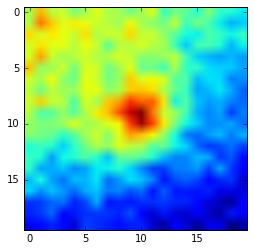

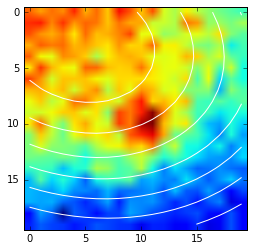

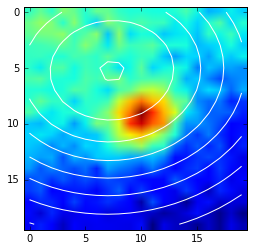

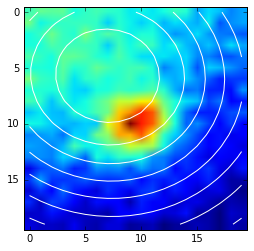

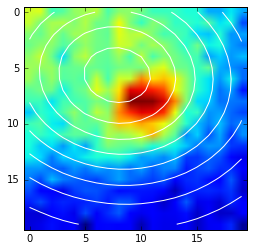

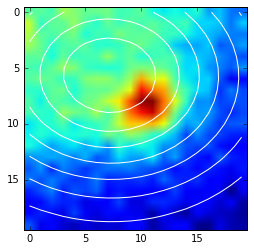

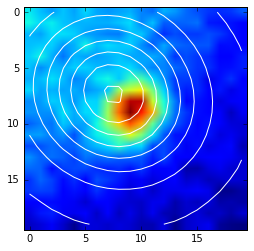

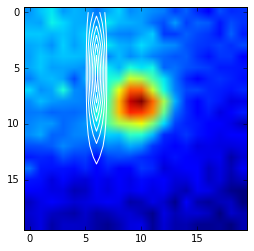

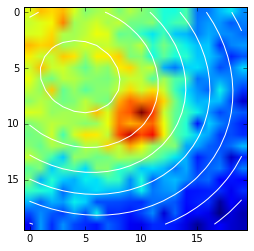

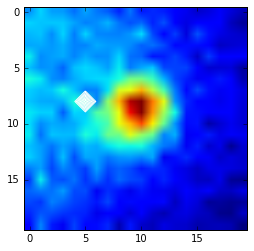

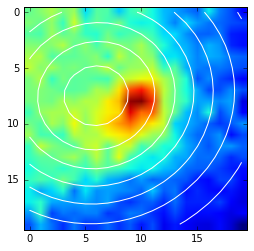

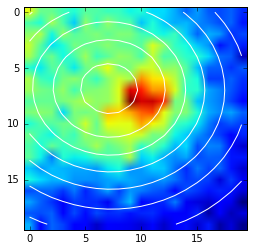

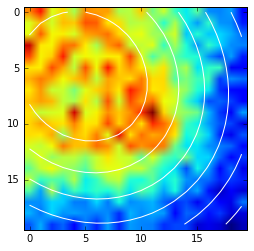

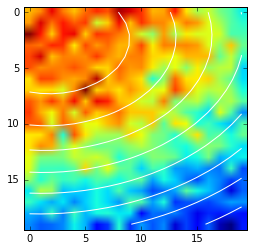

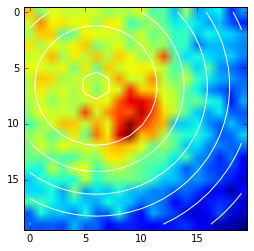

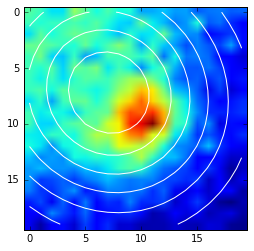

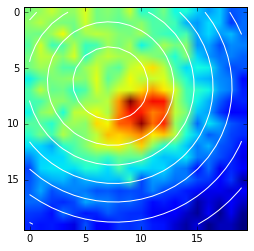

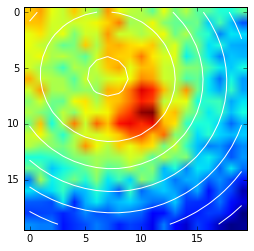

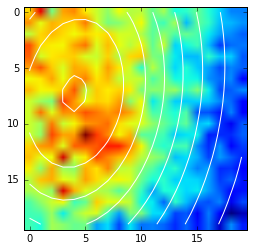

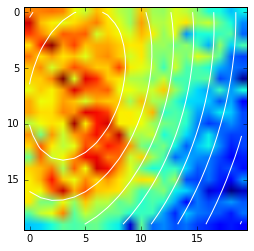

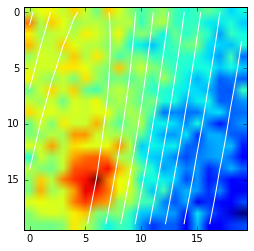

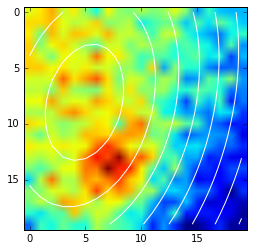

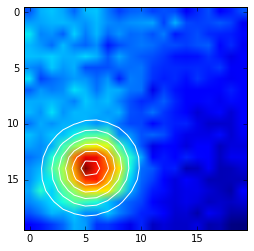

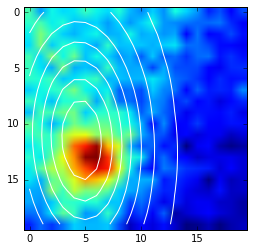

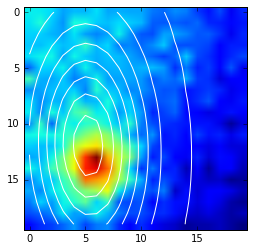

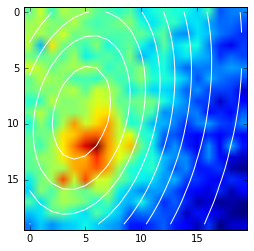

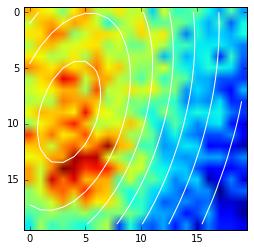

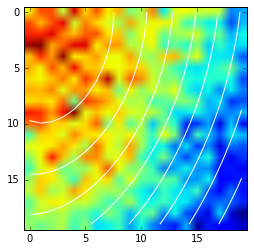

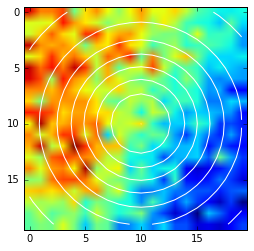

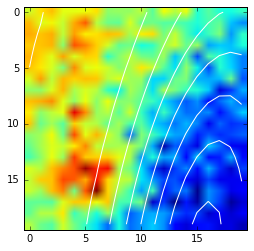

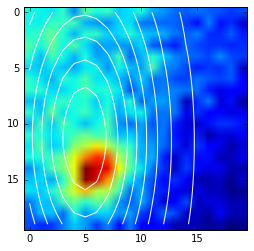

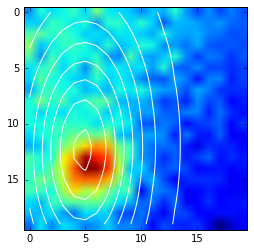

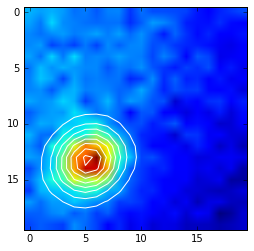

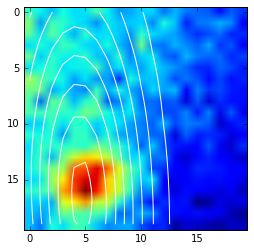

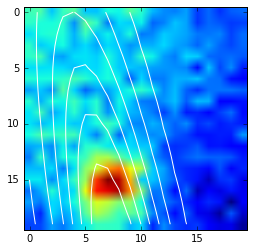

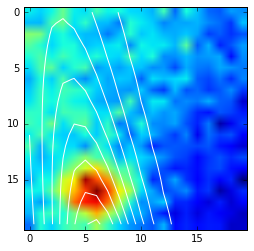

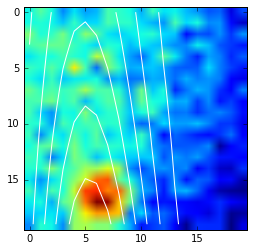

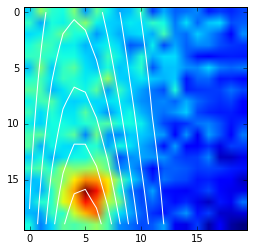

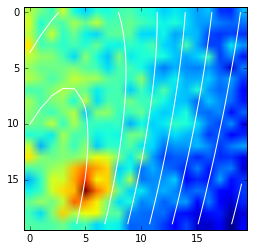

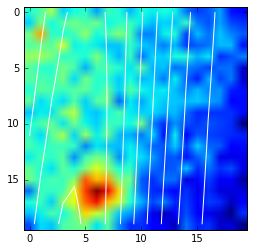

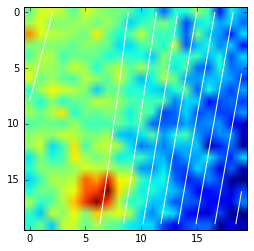

In [57]:
trackXCoordinates=np.array(trackToPlotCoordinates)[:,0]
trackYCoordinates=np.array(trackToPlotCoordinates)[:,1]
#use the average coordinate else
stack = stackA

#pixels plotted around the center of the puncta
padPM = 10

gaussianFitResults = []
gaussianFitImages = []
for frameId in range(0,len(stack)):
    #print(frameId)
    frame = stack[frameId]
    y = int(trackXCoordinates[frameId]) +1
    x = int(trackYCoordinates[frameId]) +1

    particleImage = frame[x-padPM:x+padPM,y-padPM:y+padPM]

    popt = fitGaussian(particleImage)
    gaussianFitResults.append(popt)
    if(popt[0]!=None):
        gaussianFitImages.append(plotGaussianFit(particleImage,popt,option="overlay"))
    else:
        gaussianFitImages.append(None)
    

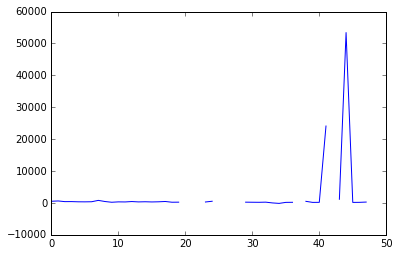

In [58]:
#print(np.asarray(gaussianFitResults))
frameId = range(0,len(gaussianFitResults))
ampl = (np.array(gaussianFitResults))[:,0]
#popt[0]-popt[6]

#offset = (np.array(gaussianFitResults[0:30]))[:,2]
#x = [row[0] for row in gaussianFitResults[1:5]]
#print(x)
plt.plot(frameId,ampl)
#plt.plot(offset)

In [24]:
test = stackA[0]

[[514 525 464 ..., 210 209 204]
 [523 468 490 ..., 203 216 186]
 [476 545 431 ..., 201 199 224]
 ..., 
 [245 211 221 ..., 123 107 116]
 [198 197 231 ..., 111 136 115]
 [194 238 199 ..., 115 120 109]]


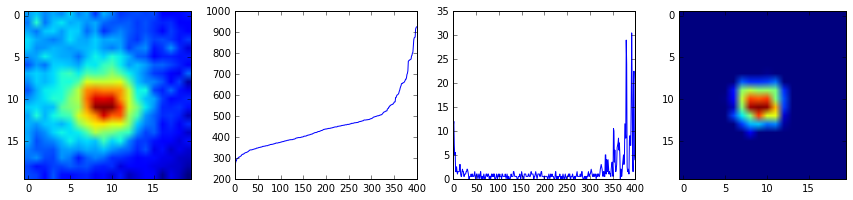

In [23]:
frameId = 10
trackXCoordinates=np.array(trackToPlotCoordinates)[:,0]
trackYCoordinates=np.array(trackToPlotCoordinates)[:,1]
#use the average coordinate else
stack = stackB
#pixels plotted around the center of the puncta
padPM = 10
frame = stack[frameId]
y = int(trackXCoordinates[frameId]) +1
x = int(trackYCoordinates[frameId]) +1

particleImage = frame[x-padPM:x+padPM,y-padPM:y+padPM]


fig, axs = plt.subplots(1, 4)
ax = axs[0]
ax.imshow(particleImage)


ax = axs[1]
ax.plot(np.sort(particleImage.flatten()))

ax = axs[2]
ax.plot(np.gradient(np.sort(particleImage.flatten())))


# clip away all values that we think do not fit
#http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.clip.html

clippedParticleImage=np.clip(particleImage, 600, np.max(particleImage))

ax = axs[3]
ax.imshow(clippedParticleImage)

fig.set_size_inches(15,3)

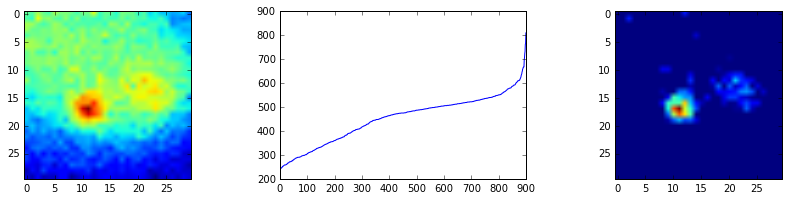

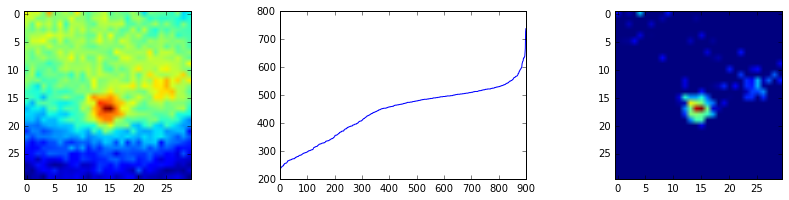

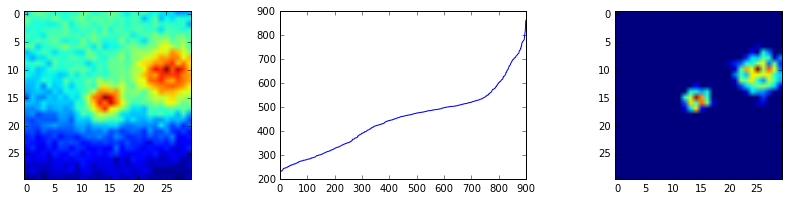

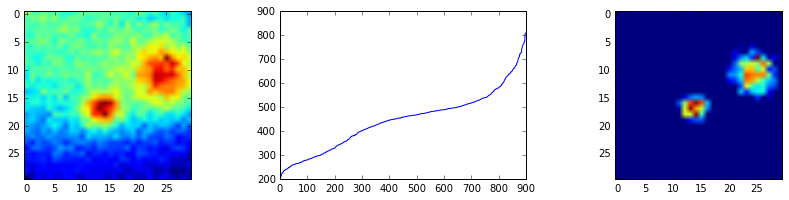

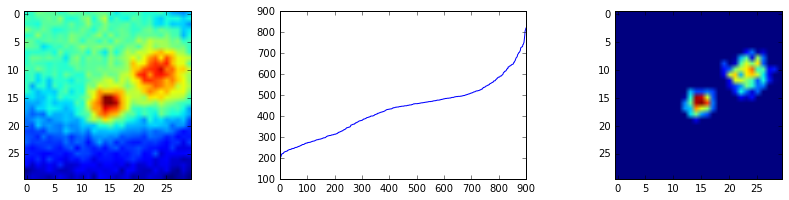

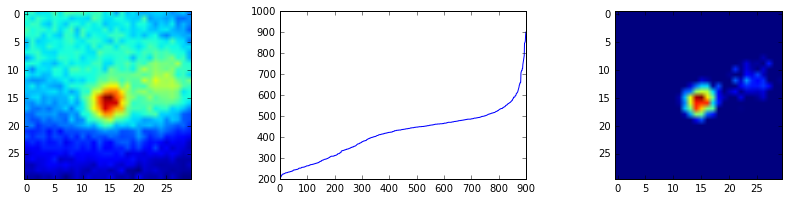

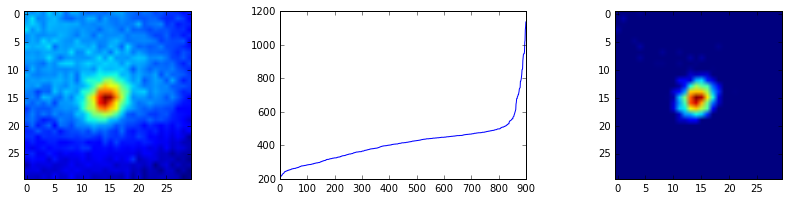

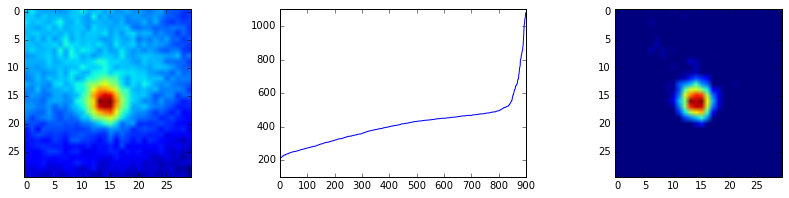

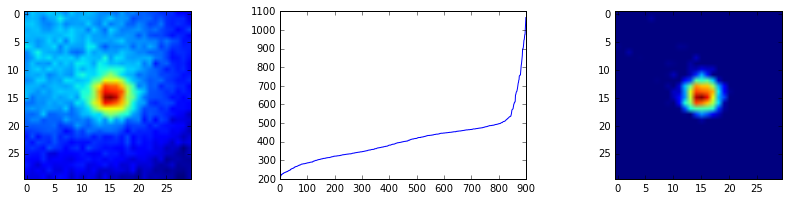

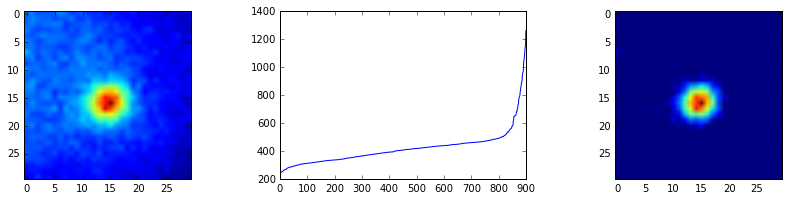

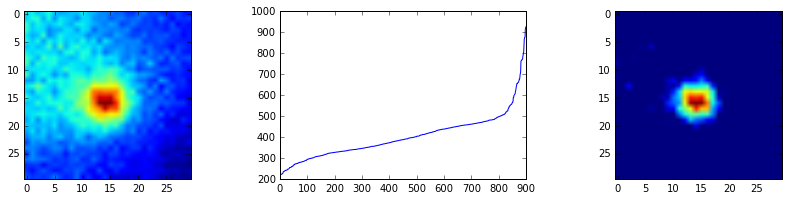

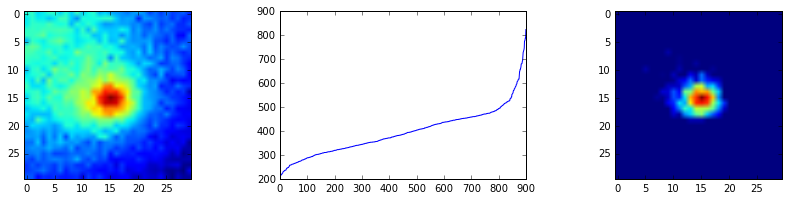

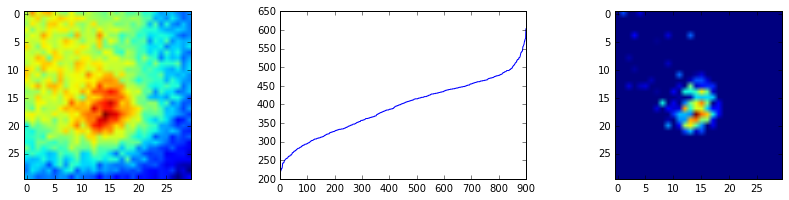

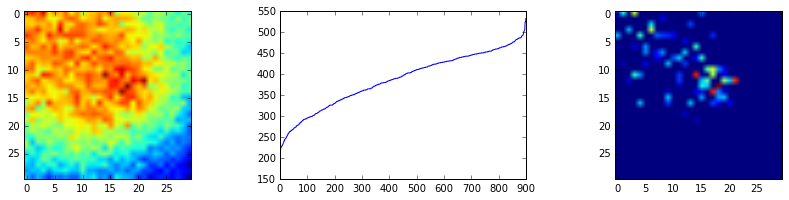

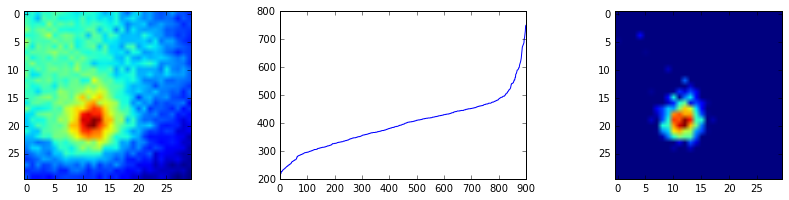

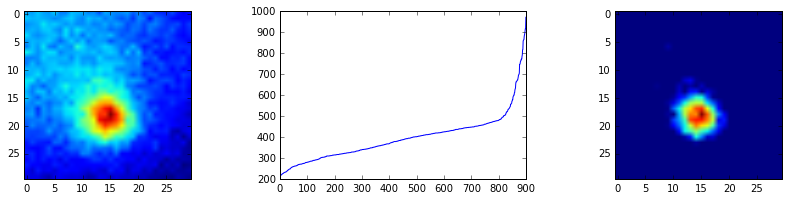

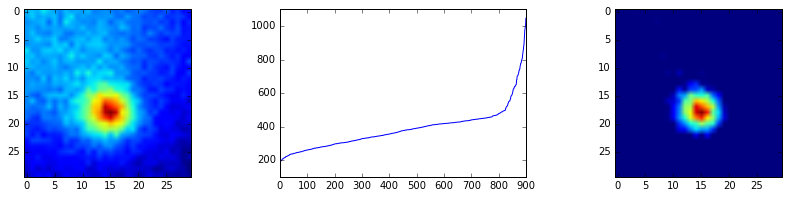

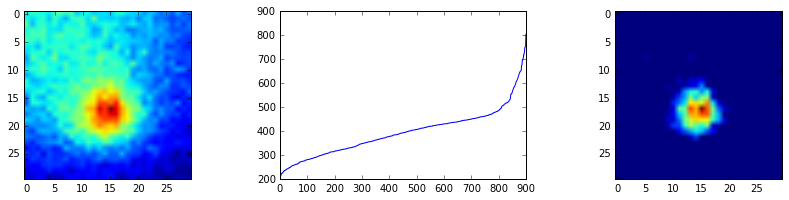

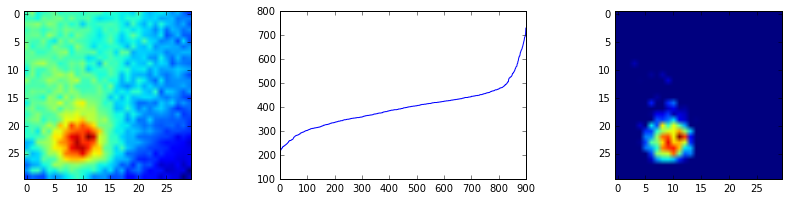

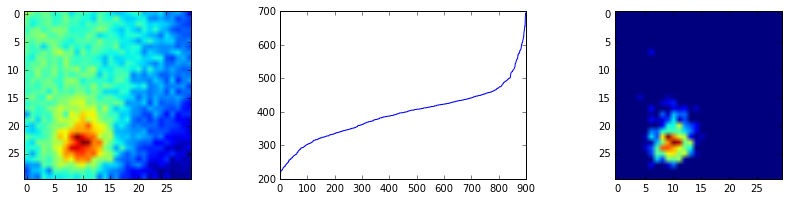

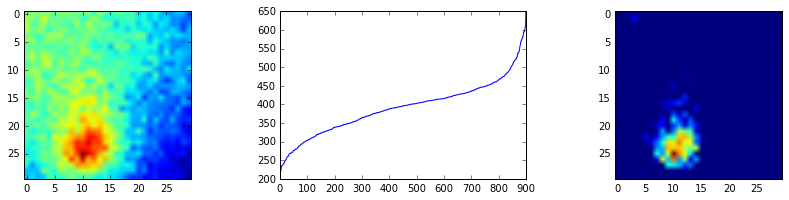

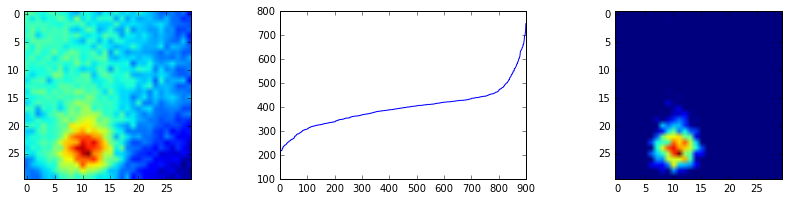

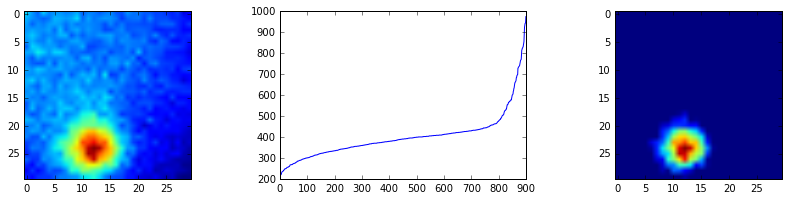

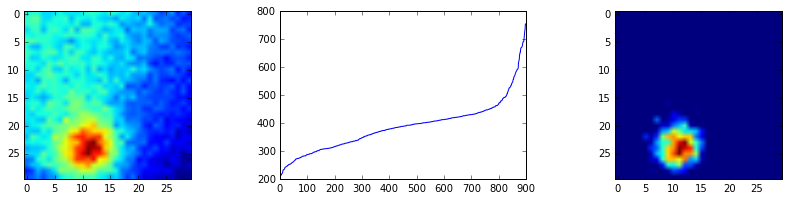

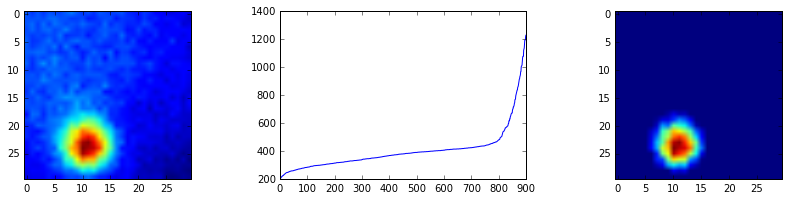

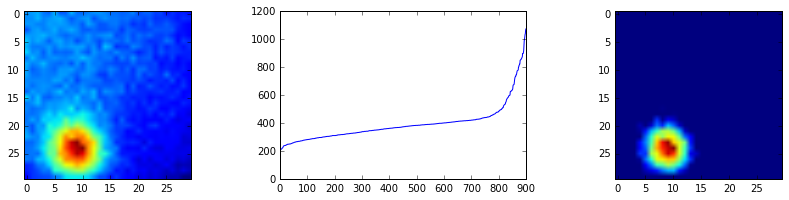

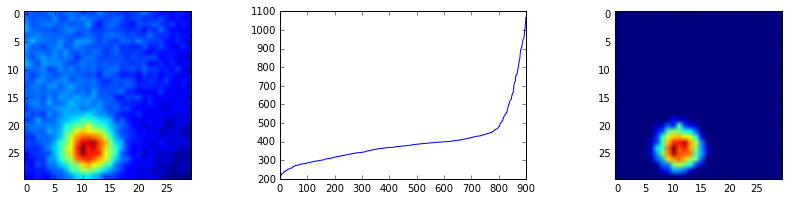

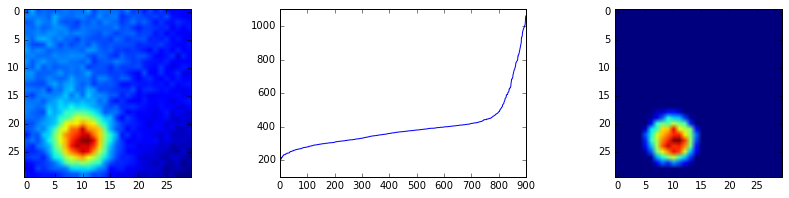

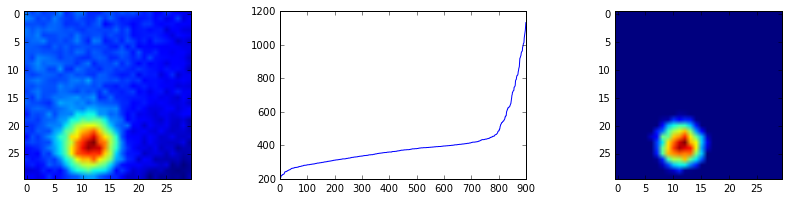

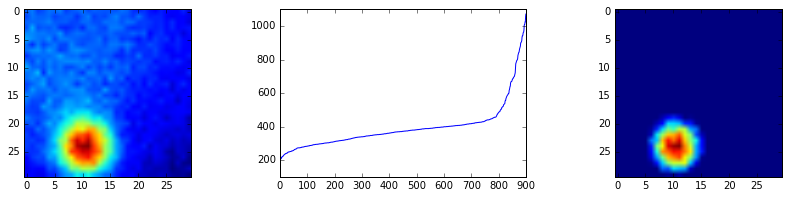

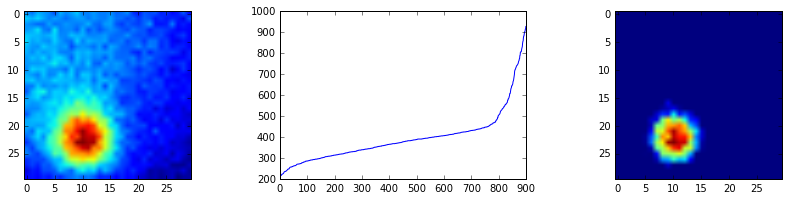

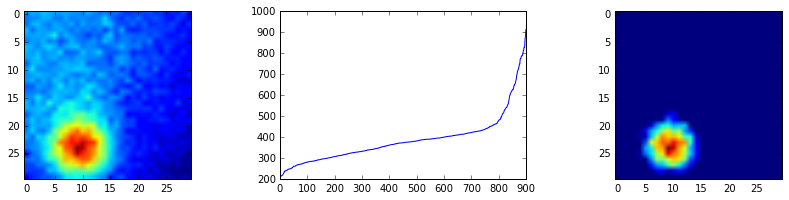

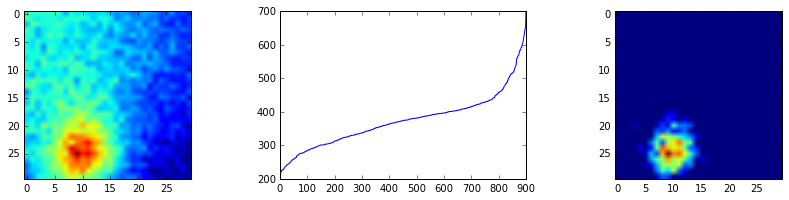

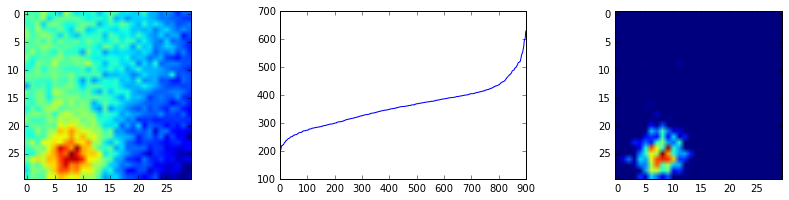

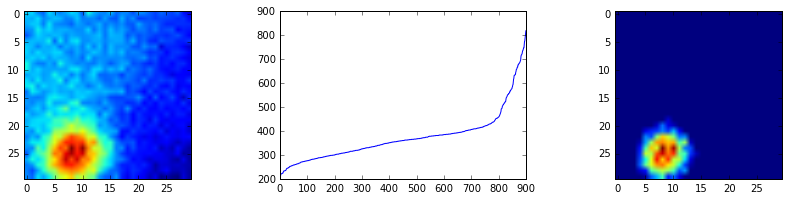

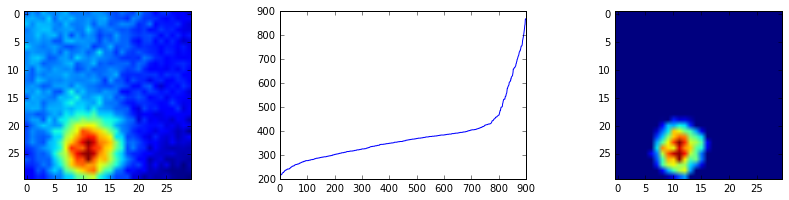

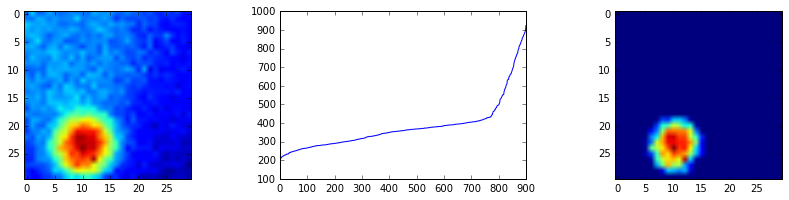

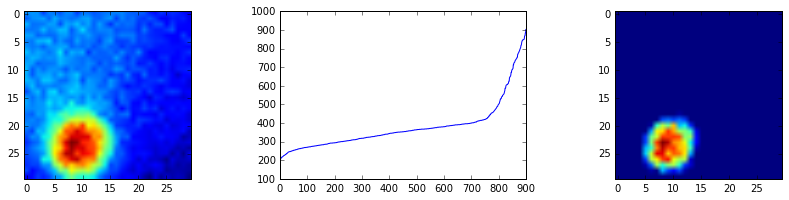

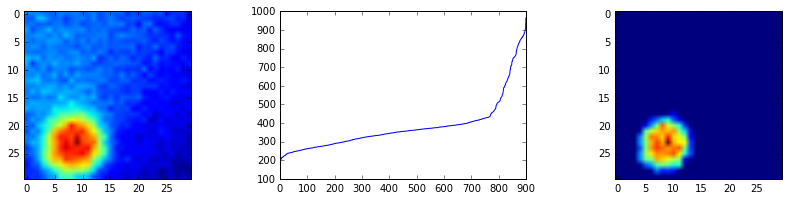

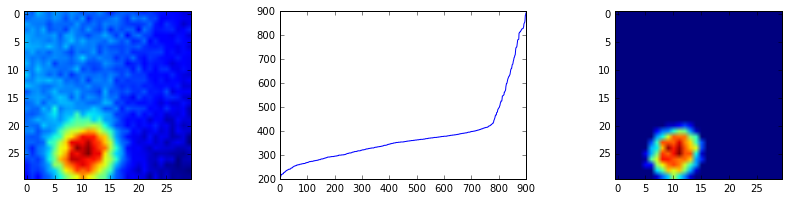

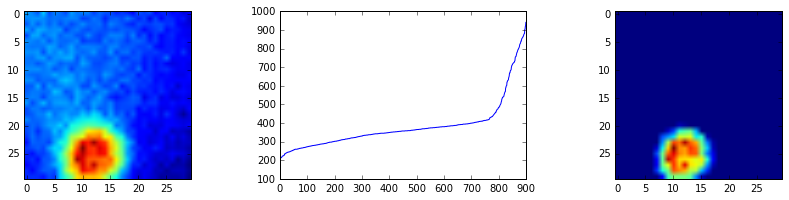

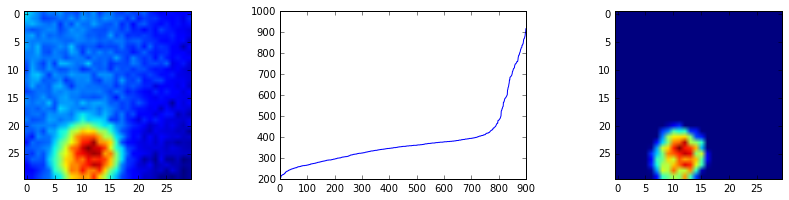

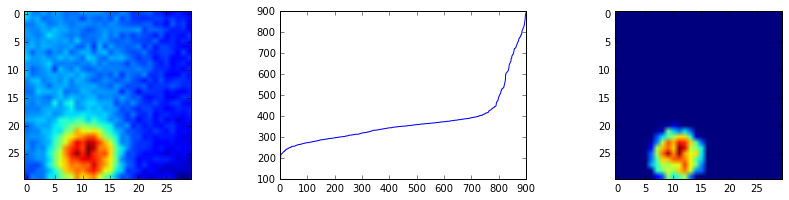

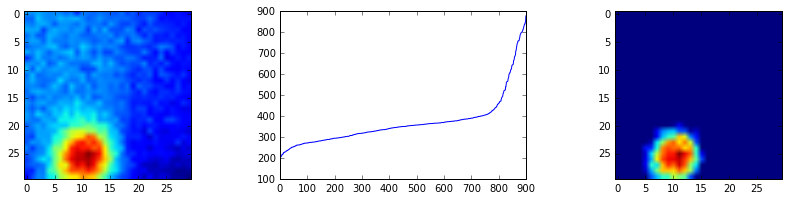

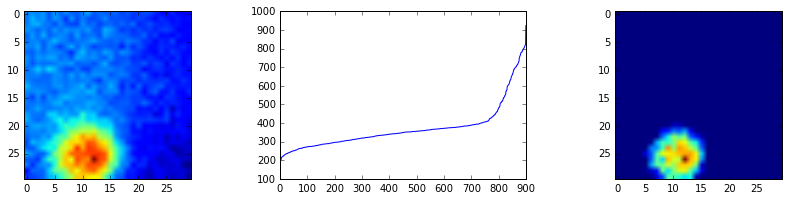

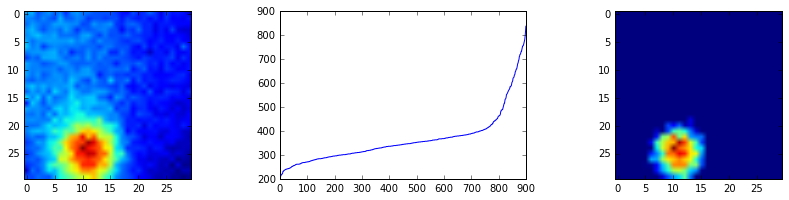

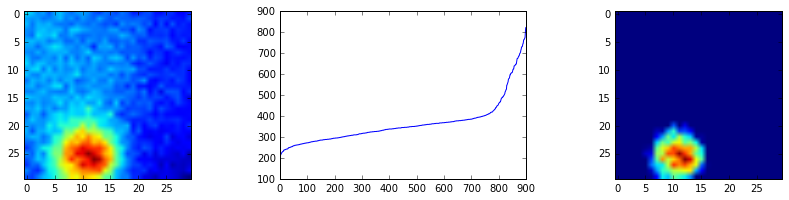

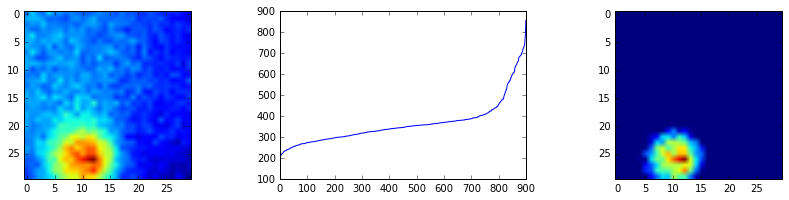

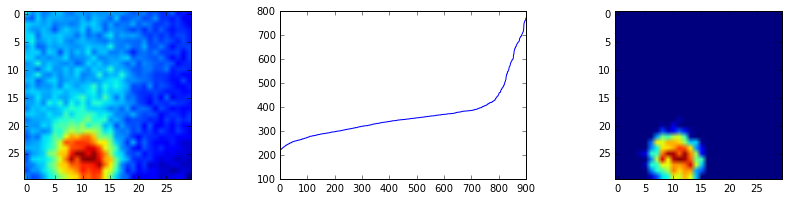

In [25]:
for frameId in range(0,49):
    trackXCoordinates=np.array(trackToPlotCoordinates)[:,0]
    trackYCoordinates=np.array(trackToPlotCoordinates)[:,1]
    #use the average coordinate else
    stack = stackB
    #pixels plotted around the center of the puncta
    padPM = 15
    frame = stack[frameId]
    y = int(trackXCoordinates[frameId]) +1
    x = int(trackYCoordinates[frameId]) +1
    
    particleImage = frame[x-padPM:x+padPM,y-padPM:y+padPM]
    
    
    fig, axs = plt.subplots(1, 3)
    ax = axs[0]
    ax.imshow(particleImage)
    
    
    ax = axs[1]
    ax.plot(np.sort(particleImage.flatten()))
    
#    ax = axs[2]
#    ax.plot(np.gradient(np.sort(particleImage.flatten())))
    
    
    # clip away all values that we think do not fit
    #http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.clip.html
    
    # we take the top 10%
    clipingIndex = int( 0.9* len(particleImage.flatten()))
    lowClipping = np.sort(particleImage.flatten())[clipingIndex]
#    print(lowClipping)
    clippedParticleImage=np.clip(particleImage, lowClipping, np.max(particleImage))
    
    ax = axs[2]
    ax.imshow(clippedParticleImage)
    
    fig.set_size_inches(15,3)
    fig.show()

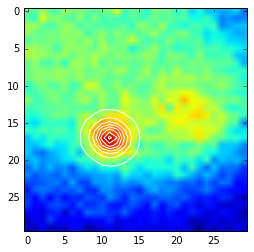

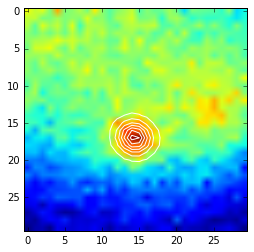

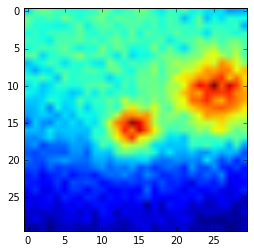

ValueError: zero-size array to reduction operation minimum which has no identity

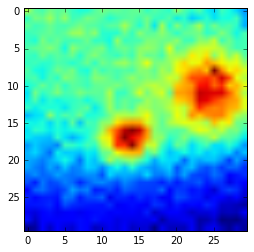

In [26]:
trackXCoordinates=np.array(trackToPlotCoordinates)[:,0]
trackYCoordinates=np.array(trackToPlotCoordinates)[:,1]
#use the average coordinate else
stack = stackB

#pixels plotted around the center of the puncta
padPM = 15

gaussianFitResults = []
gaussianFitImages = []
for frameId in range(0,len(stack)):
    #print(frameId)
    frame = stack[frameId]
    y = int(trackXCoordinates[frameId]) +1
    x = int(trackYCoordinates[frameId]) +1

    particleImage = frame[x-padPM:x+padPM,y-padPM:y+padPM]
    
    clipingIndex = int( 0.91* len(particleImage.flatten()))
    lowClipping = np.sort(particleImage.flatten())[clipingIndex]
    #    print(lowClipping)
    clippedParticleImage=np.clip(particleImage, lowClipping, np.max(particleImage))

    popt = fitGaussian(clippedParticleImage)
    gaussianFitResults.append(np.append(popt,lowClipping))
    gaussianFitImages.append(plotGaussianFit(particleImage,popt,option="overlay"))

    

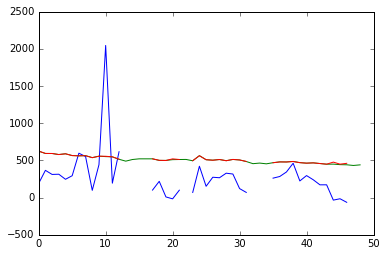

(-10, 10)

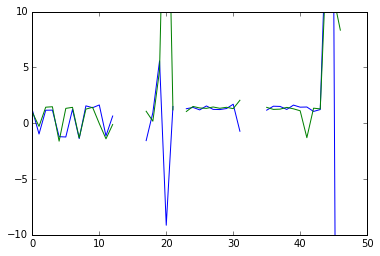

In [113]:

#print(np.asarray(gaussianFitResults))
frameId = range(0,len(gaussianFitResults))
ampl = (np.array(gaussianFitResults))[:,0]
clipOffset = (np.array(gaussianFitResults))[:,7]
sigmax = (np.array(gaussianFitResults))[:,3]
sigmay = (np.array(gaussianFitResults))[:,4]
offset = (np.array(gaussianFitResults))[:,6]
#popt[0]-popt[6]

#offset = (np.array(gaussianFitResults[0:30]))[:,2]
#x = [row[0] for row in gaussianFitResults[1:5]]
#print(x)

plt.plot(frameId,ampl)
plt.plot(frameId,clipOffset)
plt.plot(frameId,offset)
plt.show()
plt.plot(frameId,sigmax)
plt.plot(frameId,sigmay)
plt.ylim(-10,10)

#plt.plot(frameId,np.absolute(sigmax))
#plt.plot(frameId,np.absolute(sigmay))
#plt.ylim(-10,10)
#plt.plot(frameId,ampl+offset)
#plt.plot(offset)

#print(gaussianFitResults)

In [ ]:
#paramLabels = ["amplitude", "xo", "yo", "sigma_x", "sigma_y", "theta", "offset"]

#print(np.asarray(gaussianFitResults))
frameId = range(0,len(gaussianFitResults))
volumes = []
torusVolumes = []
FWHMs = []
for popt in gaussianFitResults:
    if(popt[0]!=None and popt[3]<3 and popt[4]<3 and popt[6]<600):
        FWHMx = 2.35*popt[3]
        FWHMy = 2.35*popt[4]
        # torus volume Pi r^2 h
        torusVolume = math.pi * (((FWHMx+FWHMy)/2)/2)*(((FWHMx+FWHMy)/2)/2) * popt[6]
        gaussVolume = 2* math.pi * popt[0] * popt[3]* popt[4] 
        volume = torusVolume + gaussVolume
        volumes.append(volume)
        torusVolumes.append(torusVolume)
        FWHMs.append((FWHMx,FWHMy)/2)
    else:
        volumes.append(None)
        torusVolumes.append(None)
#    print(popt)
#popt[0]-popt[6]

#offset = (np.array(gaussianFitResults[0:30]))[:,2]
#x = [row[0] for row in gaussianFitResults[1:5]]
#print(x)
plt.plot(frameId,volumes)
plt.plot(frameId,torusVolumes)
#plt.plot(offset)

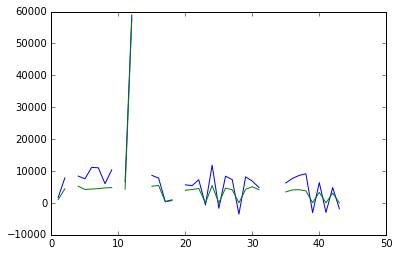

In [89]:
#paramLabels = ["amplitude", "xo", "yo", "sigma_x", "sigma_y", "theta", "offset"]

#print(np.asarray(gaussianFitResults))
frameId = range(0,len(gaussianFitResults))
volumes = []
torusVolumes = []
for popt in gaussianFitResults:
    if(popt[0]!=None and popt[3]<3 and popt[4]<3 and popt[6]<600):
        FWHMx = 2.35*popt[3]
        FWHMy = 2.35*popt[4]
        # torus volume Pi r^2 h
        torusVolume = math.pi * (((FWHMx+FWHMy)/2)/2)*(((FWHMx+FWHMy)/2)/2) * popt[6]
        gaussVolume = 2* math.pi * popt[0] * popt[3]* popt[4] 
        volume = torusVolume + gaussVolume
        volumes.append(volume)
        torusVolumes.append(torusVolume)
    else:
        volumes.append(None)
        torusVolumes.append(None)
#    print(popt)
#popt[0]-popt[6]

#offset = (np.array(gaussianFitResults[0:30]))[:,2]
#x = [row[0] for row in gaussianFitResults[1:5]]
#print(x)
plt.plot(frameId,volumes)
plt.plot(frameId,torusVolumes)
#plt.plot(offset)

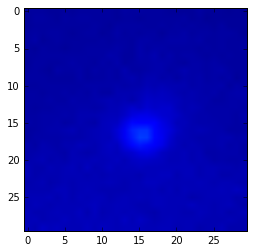

In [123]:
frameId=20
trackXCoordinates=np.array(trackToPlotCoordinates)[:,0]
trackYCoordinates=np.array(trackToPlotCoordinates)[:,1]
#use the average coordinate else
stack = stackA

#pixels plotted around the center of the puncta
padPM = 15

# the min and max values of the color map
vMax = np.max((stack[0]))
vMin = np.min((stack[0]))
  
frame = stack[frameId]
y = int(trackXCoordinates[0]) 
x = int(trackYCoordinates[0])

particleImage = frame[x-padPM:x+padPM,y-padPM:y+padPM]

plt.imshow(particleImage,vmin=vMin, vmax=vMax)
plt.colorbar(im,ax=ax)


In [48]:
#print(particleImage.reshape(len(particleImage)**2))

30
           initParam           popt           diff
amplitude      30000     838.471312   29161.528688
xo                15      15.434688      -0.434688
yo                15      16.465465      -1.465465
sigma_x            5       1.999765       3.000235
sigma_y            5       2.230134       2.769866
theta              1  122684.195594 -122683.195594
offset             1     360.094289    -359.094289


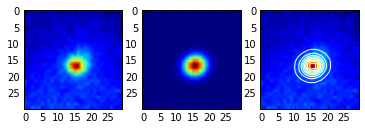

In [124]:
print(len(particleImage))
x = range(0,len(particleImage))
y = range(0,len(particleImage))
(x, y) = np.meshgrid(x, y)
# (amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
initial_guess = (30000.,len(particleImage)/2.,len(particleImage)/2.,5.,5.,1.,1.)
popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), particleImage.reshape(len(particleImage)**2), p0=initial_guess)

#print(popt)
#print("so... the theta is switched and so is the sigma x and sigma y...")

import pandas
paramLabels = ["amplitude", "xo", "yo", "sigma_x", "sigma_y", "theta", "offset"]
asdf=pandas.DataFrame(zip( initial_guess, popt,initial_guess-popt),paramLabels,["initParam","popt","diff"])
print(asdf)



data_fitted = twoD_Gaussian((x, y), *popt)
#
#print(data_fitted)
#
fig, axs = plt.subplots(1, 3)
ax = axs[0]
ax.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower')

ax = axs[1]
ax.imshow(data_fitted.reshape(len(particleImage), len(particleImage)))#,origin='lower')

ax = axs[2]
ax.hold(True)
ax.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower')
ax.contour(x, y, data_fitted.reshape(len(particleImage), len(particleImage)), 8, colors='w')



In [51]:
print(fitGaussian(particleImage))

[633.42796437852894, 3.9911487217739783, 1092.1629816671239, 4.1482030014590023, 3.8340944420889547, 458.73501728859486]


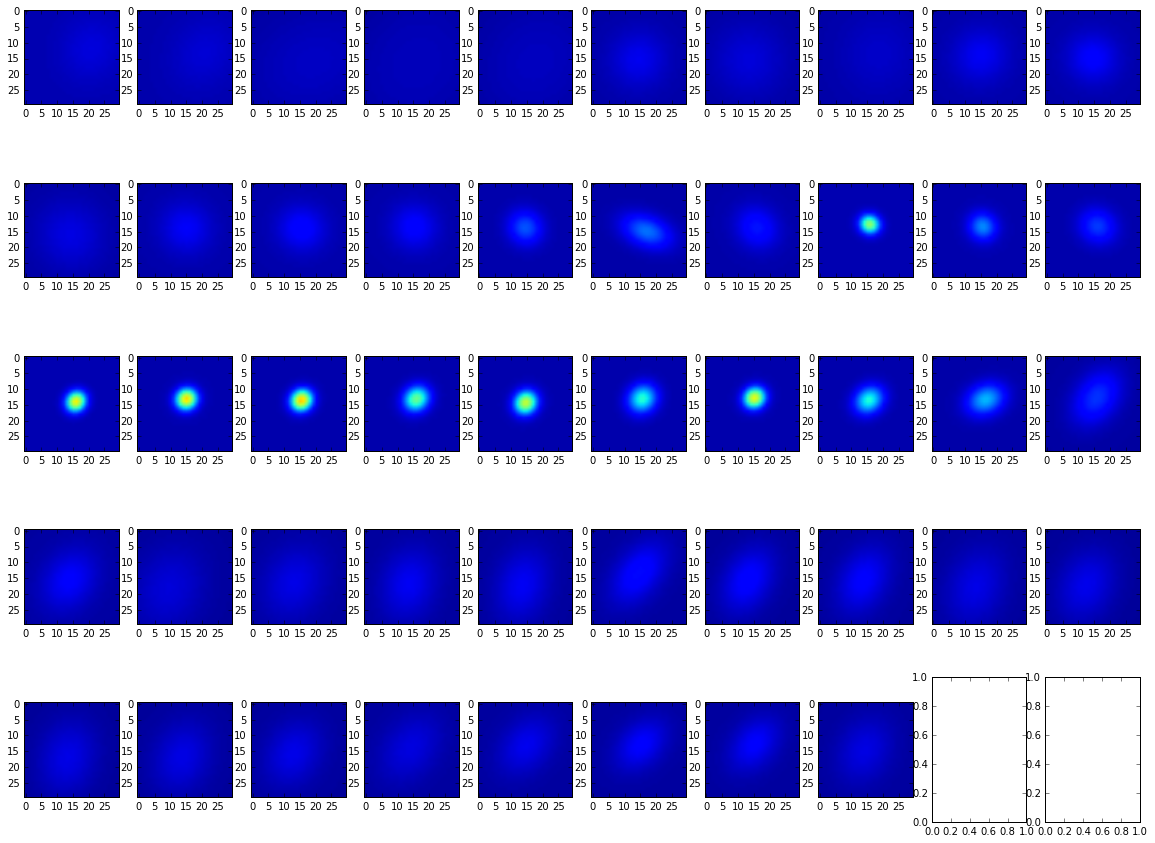

In [136]:
#use the exact coordinates when they are given

trackXCoordinates=np.array(trackToPlotCoordinates)[:,0]
trackYCoordinates=np.array(trackToPlotCoordinates)[:,1]
#use the average coordinate else
stack = stackB

#pixels plotted around the center of the puncta
padPM = 15

# the min and max values of the color map
vMax = np.max((stack[0]))
vMin = np.min((stack[0]))




#n columns for display
nColumns = 10
nRows = int(math.ceil(len(stack)/nColumns))+1
rowCounter = 0
colCounter = 0

plt.close('all')
fig, axs = plt.subplots(nrows=nRows, ncols=nColumns, sharex=False)    


for frameId in range(0,len(stack)-1):
    
    frame = stack[frameId]
    y = int(trackXCoordinates[frameId]) +1
    x = int(trackYCoordinates[frameId]) +1

    particleImage = frame[x-padPM:x+padPM,y-padPM:y+padPM]
    
    try:
        ## fitting
        x = range(0,len(particleImage))
        y = range(0,len(particleImage))
        (x, y) = np.meshgrid(x, y)
        # (amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
        initial_guess = (5000.,len(particleImage)/2.,len(particleImage)/2.,5.,5.,1.,1.)
        popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), particleImage.reshape(len(particleImage)**2), p0=initial_guess)
           
        
        data_fitted = twoD_Gaussian((x, y), *popt)
    except RuntimeError:
        #amplitude, xo, yo, sigma_x, sigma_y, theta, offset
        popt =  [0,0,0,0,0,0,0]
        data_fitted = twoD_Gaussian((x, y), *popt)
    
    
    
    


    
    
    ax = axs[rowCounter][colCounter]
    im = ax.imshow(data_fitted.reshape(len(particleImage), len(particleImage)),vmin=vMin, vmax=vMax)#,origin='lower')
#    ax.set_title("frame "+str(frameId), fontsize=8, fontweight='bold')
#    im = ax.imshow(particleImage,vmin=vMin, vmax=vMax)


    colorbar = False
    if(colorbar):
        # creates a new axis, cax, located 0.05 inches to the right of ax, whose width is 15% of ax
        # cax is used to plot a colorbar for each subplot
        div = make_axes_locatable(ax)
        cax = div.append_axes("right", size="15%", pad=0.05)
        #ticks=np.arange(0,10,.1),
        cbar = plt.colorbar(im, cax=cax,  format="%.2g")
    


    colCounter=colCounter+1;        
    if(colCounter>=nColumns):
        rowCounter = rowCounter+1;
        colCounter = 0
#    print(rowCounter,colCounter)

fig.set_size_inches(20,15)
#plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
#plt.tight_layout()     

In [134]:
trackXCoordinates=np.array(trackToPlotCoordinates)[:,0]
trackYCoordinates=np.array(trackToPlotCoordinates)[:,1]
#use the average coordinate else
stack = stackA

#pixels plotted around the center of the puncta
padPM = 15

gaussianFitResults = []
for frameId in range(0,len(stack)-1):
    #print(frameId)
    frame = stack[frameId]
    y = int(trackXCoordinates[frameId]) +1
    x = int(trackYCoordinates[frameId]) +1

    particleImage = frame[x-padPM:x+padPM,y-padPM:y+padPM]

    gaussianFitResults.append([frameId]+fitGaussian(particleImage))
    

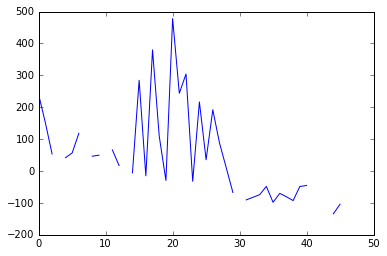

In [135]:
#print(np.asarray(gaussianFitResults))
frameId = (np.array(gaussianFitResults))[:,0]
ampl = (np.array(gaussianFitResults))[:,1]
#offset = (np.array(gaussianFitResults[0:30]))[:,2]
#x = [row[0] for row in gaussianFitResults[1:5]]
#print(x)
plt.plot(frameId,ampl)
#plt.plot(offset)

# The big cool algorithm

In [137]:
def gaussianFitTrackOnTwoImageConditions(track,stackA,stackB):
    if(len(stackA)!=len(stackB)):
        raise ValueError('lenghts of stackA and stackB are not equal') 
    
    nFrames = len(stackA)
    
    ################
    #  get the coordinates per frame
    ################

    avgPos = getAveragePositionForTrack(track)

    #use the exact coordinates when they are given in the track
    #use the average coordinate else

    punctaCoordinatePerFrame = []
    for t in range(0,nFrames):
        matchFrame = next((match for match in track if int(match[0])==t), None )
        if(matchFrame == None):
    #        print("avgPos",t)
            punctaCoordinatePerFrame.append(avgPos)
        else:
            punctaCoordinatePerFrame.append([matchFrame[1],matchFrame[2]])

    trackXCoordinates=np.array(punctaCoordinatePerFrame)[:,0]
    trackYCoordinates=np.array(punctaCoordinatePerFrame)[:,1]        
    
    ################
    #  parse out the image for each condition and fit the gaussian
    ################
    
    #pixels taken into account around the center of the puncta
    #######
    #This is YUUUUGELY important
    #######
    padPM = 15

    gaussianFitResults = []
    for frameId in range(0,nFrames-1):
    
    ### condition A
        frame = stackA[frameId]
        y = int(trackXCoordinates[frameId]) +1
        x = int(trackYCoordinates[frameId]) +1
        particleImageA = frame[x-padPM:x+padPM,y-padPM:y+padPM]
        resultImageA = fitGaussian(particleImageA)
        
    ### condition A
        frame = stackB[frameId]
        y = int(trackXCoordinates[frameId]) +1
        x = int(trackYCoordinates[frameId]) +1
        particleImageB = frame[x-padPM:x+padPM,y-padPM:y+padPM]
        resultImageB = fitGaussian(particleImageB)
        
        
        gaussianFitResults.append([frameId]+resultImageA+resultImageB)
#        if(frameId%10==0):
            #print("frame ",frameId)
    
    return gaussianFitResults
    
    
    

In [138]:
results = gaussianFitTrackOnTwoImageConditions(mergedTracks[11],stackA,stackB)

In [139]:
def nanNormalize(list):
    result = []
    for item in list:
        if(item!=None):
            result.append(item/max(list))
        else:
            result.append(None)
    return(result)

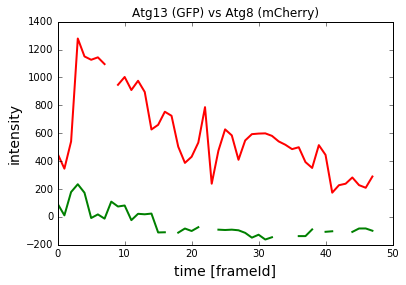

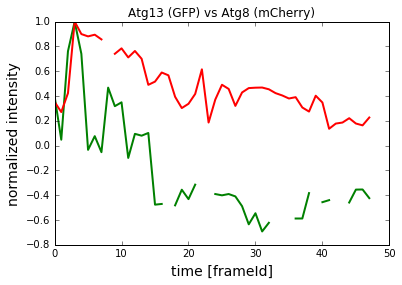

In [140]:
#print(np.asarray(gaussianFitResults))
frameId = (np.array(results))[:,0]
amplA = (np.array(results))[:,1]
amplB = (np.array(results))[:,7]
#offset = (np.array(gaussianFitResults[0:30]))[:,2]
#x = [row[0] for row in gaussianFitResults[1:5]]
#print(x)

#plt.plot(frameId,amplA/max(amplA),color="green",linewidth=2)
#sum()
#plt.plot(frameId,filter(1, amplA)/max(amplA),color="green",linewidth=2)
plt.plot(frameId,amplA,color="green",linewidth=2)
plt.plot(frameId,amplB,color="red",linewidth=2)
plt.title("Atg13 (GFP) vs Atg8 (mCherry)")
plt.xlabel("time [frameId]", fontsize=14, fontweight='regular')
plt.ylabel("intensity", fontsize=14, fontweight='regular')
plt.show()

plt.plot(frameId,nanNormalize(amplA),color="green",linewidth=2)
plt.plot(frameId,nanNormalize(amplB),color="red",linewidth=2)
plt.title("Atg13 (GFP) vs Atg8 (mCherry)")
plt.xlabel("time [frameId]", fontsize=14, fontweight='regular')
plt.ylabel("normalized intensity", fontsize=14, fontweight='regular')
plt.show()

# Look at all the data

In [141]:
len(mergedTracks)

In [142]:
#write the data
import csv

mergedTracksResults = []
for i in range(0,len(mergedTracks)):
    try:
        results = gaussianFitTrackOnTwoImageConditions(mergedTracks[i],stackA,stackB)
        mergedTracksResults.append(results)
        with open('output/mergedTracksResults_'+str(i)+'.csv', 'wb') as csvfile:
            csvWriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            for row in results:
                csvWriter.writerow(row)
        print(i)
    except TypeError:
        print(i, "oops")
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


ValueError: could not convert string to float: 

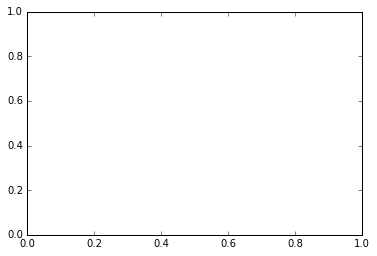

In [78]:
#read and plot the data
import csv
for i in range(33,len(mergedTracks)):
    with open('output/mergedTracksResults_'+str(i)+'.csv', 'rb') as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',', quotechar='|')
        results = []
        for row in csvReader:
            results.append(row)
        #print(results)        
        frameId = (np.array(results))[:,0]
        amplA = (np.array(results))[:,1]
        amplB = (np.array(results))[:,7]
        
        plt.plot(frameId,amplA,color="green",linewidth=2)
        plt.plot(frameId,amplB,color="red",linewidth=2)
        plt.title("Atg1 (GFP) vs Atg8 (mCherry)")
        plt.xlabel("time [frameId]", fontsize=14, fontweight='regular')
        plt.ylabel("intensity", fontsize=14, fontweight='regular')
        show()

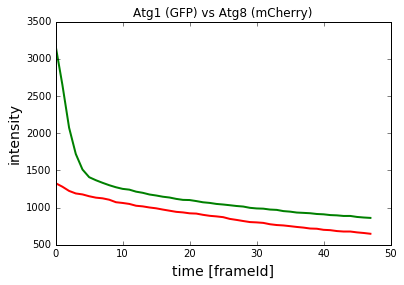

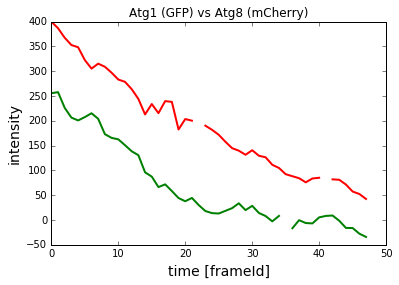

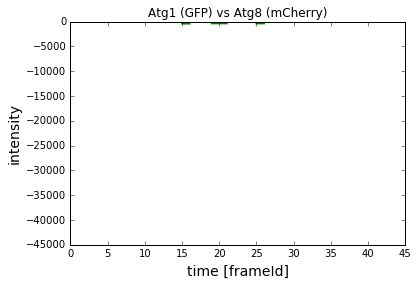

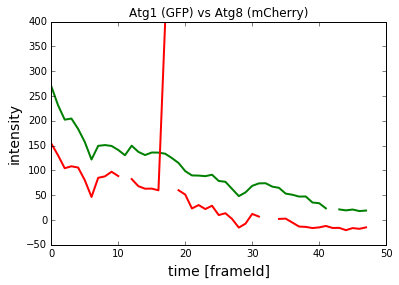

In [80]:
for results in mergedTracksResults:
    frameId = (np.array(results))[:,0]
    amplA = (np.array(results))[:,1]
    amplB = (np.array(results))[:,7]

    plt.plot(frameId,amplA,color="green",linewidth=2)
    plt.plot(frameId,amplB,color="red",linewidth=2)
    plt.title("Atg1 (GFP) vs Atg8 (mCherry)")
    plt.xlabel("time [frameId]", fontsize=14, fontweight='regular')
    plt.ylabel("intensity", fontsize=14, fontweight='regular')
    show()


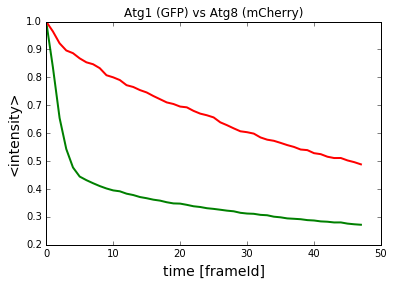

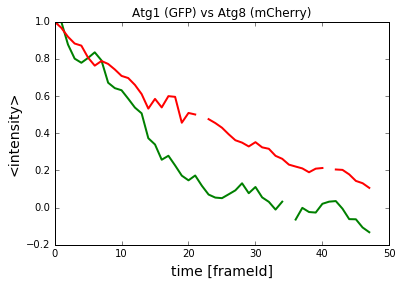

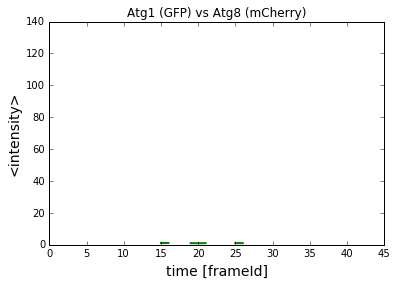

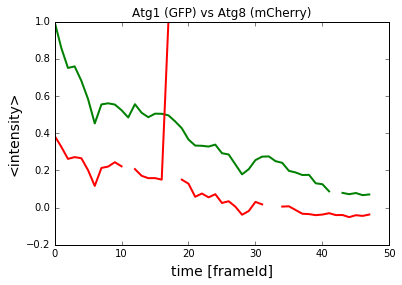

In [79]:
for results in mergedTracksResults:
    frameId = (np.array(results))[:,0]
    amplA = (np.array(results))[:,1]
    amplB = (np.array(results))[:,7]

    plt.plot(frameId,nanNormalize(amplA),color="green",linewidth=2)
    plt.plot(frameId,nanNormalize(amplB),color="red",linewidth=2)
    plt.title("Atg1 (GFP) vs Atg8 (mCherry)")
    plt.xlabel("time [frameId]", fontsize=14, fontweight='regular')
    plt.ylabel("<intensity>", fontsize=14, fontweight='regular')
    plt.show()

# doesnt look so good... the gaussian fitting. Go with summation

In [63]:
def intensitySquareSumForTrackOnTwoImageConditions(track,stackA,stackB):
    if(len(stackA)!=len(stackB)):
        raise ValueError('lenghts of stackA and stackB are not equal') 
    
    nFrames = len(stackA)
    
    ################
    #  get the coordinates per frame
    ################

    avgPos = getAveragePositionForTrack(track)

    #use the exact coordinates when they are given in the track
    #use the average coordinate else

    punctaCoordinatePerFrame = []
    for t in range(0,nFrames):
        matchFrame = next((match for match in track if int(match[0])==t), None )
        if(matchFrame == None):
    #        print("avgPos",t)
            punctaCoordinatePerFrame.append(avgPos)
        else:
            punctaCoordinatePerFrame.append([matchFrame[1],matchFrame[2]])

    trackXCoordinates=np.array(punctaCoordinatePerFrame)[:,0]
    trackYCoordinates=np.array(punctaCoordinatePerFrame)[:,1]        
    
    ################
    #  parse out the image for each condition and fit the gaussian
    ################
    
    #pixels taken into account around the center of the puncta
    padPM = 7

    summationResults = []
    for frameId in range(0,nFrames-1):
    
    ### condition A
        frame = stackA[frameId]
        y = int(trackXCoordinates[frameId]) +1
        x = int(trackYCoordinates[frameId]) +1
        particleImageA = frame[x-padPM:x+padPM,y-padPM:y+padPM]
        resultImageA = np.sum(particleImageA)
        
    ### condition A
        frame = stackB[frameId]
        y = int(trackXCoordinates[frameId]) +1
        x = int(trackYCoordinates[frameId]) +1
        particleImageB = frame[x-padPM:x+padPM,y-padPM:y+padPM]
        resultImageB = np.sum(particleImageB)
        
        
        summationResults.append([frameId]+[resultImageA]+[resultImageB])
#        if(frameId%10==0):
            #print("frame ",frameId)
    
    return summationResults
    
    
    

In [64]:
import csv

allTracks = uniqueTracksA+uniqueTracksB+mergedTracksAB


for i in range(0,len(allTracks)):
    results = intensitySquareSumForTrackOnTwoImageConditions(allTracks[i],stackA,stackB)
    with open('output/summation_allTracksResults_'+str(i)+'.csv', 'wb') as csvfile:
        csvWriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in results:
            csvWriter.writerow(row)
    print(i)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# do a control with random points that we put everywhere on the display

In [49]:
# this works as follows
# i only give him random initial coordinates.
# the other algorithms will figure out the average coordinates (the sole one given)
# and fill the others accordingly.

randomTracks = []
for i in range(0,len(stackA[0]),250):
    for j in range(0,len(stackA[0][0]),250):
        #print(i,j)
        randomTracks.append([[0.0,i,j],[1.0,i,j]])


for i in range(0,len(randomTracks)):
    results = intensitySquareSumForTrackOnTwoImageConditions(randomTracks[i],stackA,stackB)
    with open('summation_randomTracksResults_'+str(i)+'.csv', 'wb') as csvfile:
        csvWriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in results:
            csvWriter.writerow(row)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
